<a href="https://colab.research.google.com/github/noahruiz416/Airline_On_Time_AZ_Market/blob/main/Airline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook we will build a regression model based of the findings in the EDA. Additionally rudeimentary feature engineering will be used to find the best features to feed into the regression model 

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive 
from sklearn.linear_model import LinearRegression
from scipy import stats
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
airline_aggr_data = pd.read_csv("gdrive/My Drive/bq-results-20220226-154935-8t4st3sl5exn/ad.csv")
airline_aggr_data = airline_aggr_data.fillna(value = 0)

In [ ]:
#calculating inflation factors / mutlicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Here we use the VIF, to test for collinearity between variables. After doing so we create various interaction terms, for variables that have high collinearity

In [ ]:
#checking for independence between variables detected factors
x = airline_aggr_data[['DepDelay', 'CarrierDelay', 'WeatherDelay', 
        'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Distance', 'TaxiOut', 'TaxiIn']]
calc_vif(x)

,variables,VIF
0,DepDelay,13.668774
1,CarrierDelay,6.616666
2,WeatherDelay,1.360376
3,NASDelay,1.985785
4,SecurityDelay,1.030361
5,LateAircraftDelay,5.433587
6,Distance,2.770194
7,TaxiOut,2.705729
8,TaxiIn,2.084327


In [ ]:
airline_aggr_data['interaction_dep_carrier'] = airline_aggr_data['DepDelay'] * airline_aggr_data['CarrierDelay']
airline_aggr_data['interaction_late'] = airline_aggr_data['DepDelay'] * airline_aggr_data['LateAircraftDelay']
airline_aggr_data['interaction_late_carrier'] = airline_aggr_data['CarrierDelay'] * airline_aggr_data['LateAircraftDelay']

## In this section, we iterate through multiple models, in order to find the best fit model for arrival delay.

In [ ]:
from sklearn.model_selection import train_test_split
#complete model with interaction terms
X = airline_aggr_data[['DepDelay', 'CarrierDelay', 'LateAircraftDelay', 'interaction_dep_carrier', 'interaction_late']]
y = airline_aggr_data['ArrDelay']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

In [ ]:
regr = LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.9089800848575267


In [ ]:
#reduced model
X = airline_aggr_data[['DepDelay', 'CarrierDelay', 'LateAircraftDelay']]
y = airline_aggr_data['ArrDelay']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

regr = LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.907225563983596


In [ ]:
#model ignoring any internaction between terms, and instead focusing on terms with low colinearity, with excepction of departure delay
X = airline_aggr_data[['DepDelay', 'SecurityDelay', 'WeatherDelay', 'NASDelay']]
y = airline_aggr_data['ArrDelay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

regr = LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.9330092677738395


In [ ]:
#Model with low colinnearity + interaction between all variables
X = airline_aggr_data[['DepDelay', 'CarrierDelay', 'SecurityDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'interaction_dep_carrier', 'interaction_late', 'interaction_late_carrier']]
y = airline_aggr_data['ArrDelay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

regr = LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.9745001347623109


In [ ]:
#Low Collinearity + Interaction between departure delay and carrier delay, and interaction between departure delay and late aircraft delay
X = airline_aggr_data[['DepDelay', 'CarrierDelay', 'SecurityDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'interaction_dep_carrier', 'interaction_late', 'interaction_late_carrier']]
y = airline_aggr_data['ArrDelay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

regr = LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.9776455909179711


## In this section we use various different metrics other than the, regression train score to test the effectiveness of our best models

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
def metrics(model, prediction_data, data):
  predicted_y_values = model.predict(prediction_data)
  actual_y_values = data['ArrDelay']

  r_square = r2_score(actual_y_values, predicted_y_values)
  explained_var = explained_variance_score(actual_y_values, predicted_y_values)
  max_err = max_error(actual_y_values, predicted_y_values)
  mean_abs_err = mean_absolute_error(actual_y_values, predicted_y_values)
  mse = mean_squared_error(actual_y_values, predicted_y_values)

  metrics = {'Coeffcient Of Determination': round(r_square, 4),
             'Explained Variance'         : f"{round(explained_var*100, 4)}%",
             'Maximum Error'              : round(max_err, 4),
             'Mean Absolute Error'        : round(mean_abs_err, 4),
             'Mean Squared Error'         : round(mse, 4)}
  return metrics

In [ ]:
#best model with interaction
X = airline_aggr_data[['DepDelay', 'CarrierDelay', 'SecurityDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'interaction_dep_carrier', 'interaction_late', 'interaction_late_carrier']]
y = airline_aggr_data['ArrDelay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

regr = LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.9783837059817067


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


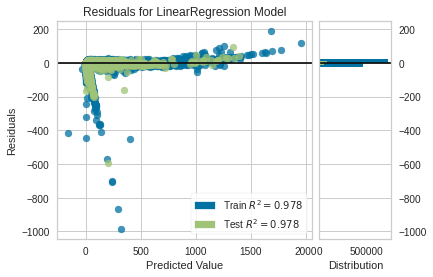

In [ ]:
visualizer = ResidualsPlot(regr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show() 

In [ ]:
#testing complete model
predicted_y_values = regr.predict(X)
actual_y_values = airline_aggr_data['ArrDelay']

In [ ]:
metrics(regr, X, airline_aggr_data)

{'Coeffcient Of Determination': 0.9779,
 'Explained Variance': '97.7904%',
 'Maximum Error': 985.0191,
 'Mean Absolute Error': 3.4439,
 'Mean Squared Error': 35.4476}

In [ ]:
#best model without interaction, 'reduced' model
X1 = airline_aggr_data[['DepDelay', 'CarrierDelay', 'SecurityDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']]
y1 = airline_aggr_data['ArrDelay']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.10)

regr1 = LinearRegression()
regr1.fit(X1_train, y1_train)
print(regr1.score(X1_test, y1_test))

0.9762300759075875


In [ ]:
#testing reduced model 
predicted_y_values = regr1.predict(X1)
actual_y_values = airline_aggr_data['ArrDelay']

In [ ]:
metrics(regr1, X1, airline_aggr_data)

{'Coeffcient Of Determination': 0.9772,
 'Explained Variance': '97.7176%',
 'Maximum Error': 988.3757,
 'Mean Absolute Error': 3.5362,
 'Mean Squared Error': 36.6162}

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


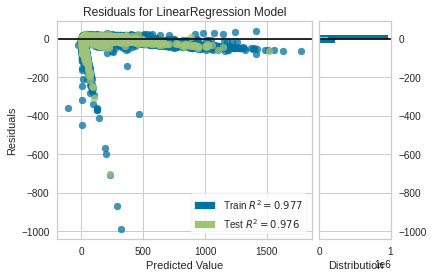

In [ ]:
#residuals plot
visualizer = ResidualsPlot(regr1)

visualizer.fit(X1_train, y1_train)  # Fit the training data to the visualizer
visualizer.score(X1_test, y1_test)  # Evaluate the model on the test data
visualizer.show()  

## In this block of code we import a csv file of arrival delay times in 2021, and try to use our models to predict 'Arrival Delays' in 2021. We then compare both of the models accuracy, using our metrics function. Additionally, a few lines of code are reserved for column labeling for the new dataset.

In [ ]:
airline_aggr_data = pd.read_csv("gdrive/My Drive/combined_csv.csv")
delay_times_2021 = airline_aggr_data.fillna(value = 0)

In [ ]:
filter1 = delay_times_2021['ARR_DELAY'] > 0
filter2 = delay_times_2021['YEAR'] >= 2021
delay_times_2021_filtered = delay_times_2021.where(filter1 & filter2)
delay_times_2021_filtered = delay_times_2021_filtered.dropna()


In [ ]:
#renaming columns
delay_times_2021_filtered['DepDelay'] = delay_times_2021_filtered['DEP_DELAY']
delay_times_2021_filtered['CarrierDelay'] = delay_times_2021_filtered['CARRIER_DELAY']
delay_times_2021_filtered['SecurityDelay'] = delay_times_2021_filtered['SECURITY_DELAY']
delay_times_2021_filtered['WeatherDelay'] = delay_times_2021_filtered['WEATHER_DELAY']
delay_times_2021_filtered['NASDelay'] = delay_times_2021_filtered['NAS_DELAY']
delay_times_2021_filtered['LateAircraftDelay'] = delay_times_2021_filtered['LATE_AIRCRAFT_DELAY']
delay_times_2021_filtered['ArrDelay'] = delay_times_2021_filtered['ARR_DELAY']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
delay_times_2021_filtered['interaction_dep_carrier'] = delay_times_2021_filtered['DEP_DELAY'] * delay_times_2021_filtered['CARRIER_DELAY']
delay_times_2021_filtered['interaction_late'] = delay_times_2021_filtered['DEP_DELAY'] * delay_times_2021_filtered['LATE_AIRCRAFT_DELAY']
delay_times_2021_filtered['interaction_late_carrier'] = delay_times_2021_filtered['CARRIER_DELAY'] * delay_times_2021_filtered['LATE_AIRCRAFT_DELAY']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#using our interaction model with 2021 data
X_2021 = delay_times_2021_filtered[['DepDelay', 'CarrierDelay', 'SecurityDelay', 'WeatherDelay',
                                    'NASDelay', 'LateAircraftDelay', 'interaction_dep_carrier', 'interaction_late','interaction_late_carrier']]
y_2021 = delay_times_2021_filtered['ArrDelay']

predicted_y_values = regr.predict(X)
actual_y_values_2021 = delay_times_2021_filtered['ArrDelay']

In [ ]:
metrics(regr, X_2021, delay_times_2021_filtered)

{'Coeffcient Of Determination': 0.9956,
 'Explained Variance': '99.5637%',
 'Maximum Error': 295.2571,
 'Mean Absolute Error': 3.4666,
 'Mean Squared Error': 25.9138}

In [ ]:
#using our reduced model with 2021 data
X1_2021 = delay_times_2021_filtered[['DepDelay', 'CarrierDelay', 'SecurityDelay', 'WeatherDelay',
                                    'NASDelay', 'LateAircraftDelay']]
y_2021 = delay_times_2021_filtered['ArrDelay']

predicted_y_values = regr1.predict(X1_2021)
actual_y_values_2021 = delay_times_2021_filtered['ArrDelay']

In [ ]:
metrics(regr1, X1_2021, delay_times_2021_filtered)

{'Coeffcient Of Determination': 0.9958,
 'Explained Variance': '99.5815%',
 'Maximum Error': 100.9337,
 'Mean Absolute Error': 3.6075,
 'Mean Squared Error': 24.7765}

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

In [ ]:
delay_times_2021_filtered['Predicted'] = predicted_y_values

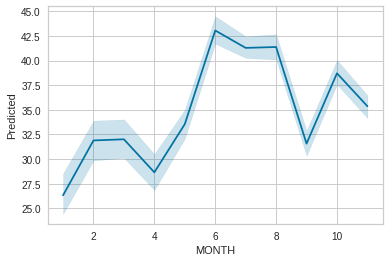

In [ ]:
sns.lineplot(x = 'MONTH', y = 'Predicted', data = delay_times_2021_filtered)

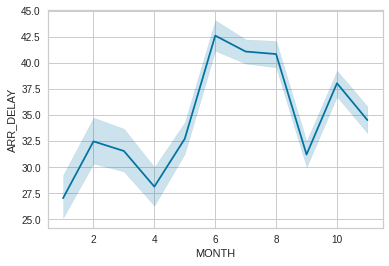

In [ ]:
sns.lineplot(x = 'MONTH', y = 'ARR_DELAY', data = delay_times_2021_filtered)

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X1_2021, y_2021, test_size = 0.10)

regr1.fit(X2_train, y2_train)
print(regr1.score(X2_test, y2_test))

0.9977624878258475


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


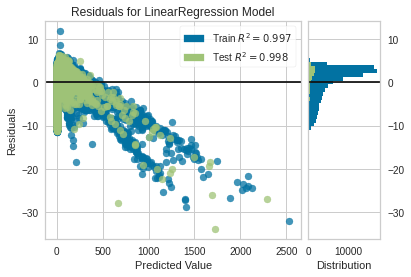

In [ ]:
visualizer0 = ResidualsPlot(regr1)


visualizer0.fit(X2_train, y2_train)  # Fit the training data to the visualizer
visualizer0.score(X2_test, y2_test)  # Evaluate the model on the test data
visualizer0.show()                   # Finalize and render the figure